# Imports and hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
import gc

import optuna
import logging

from collections.abc import Callable

from pso_utils import *
from landscapes import *

# Utils

In [2]:
# plotting utils
lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()

# Landscapes plotting

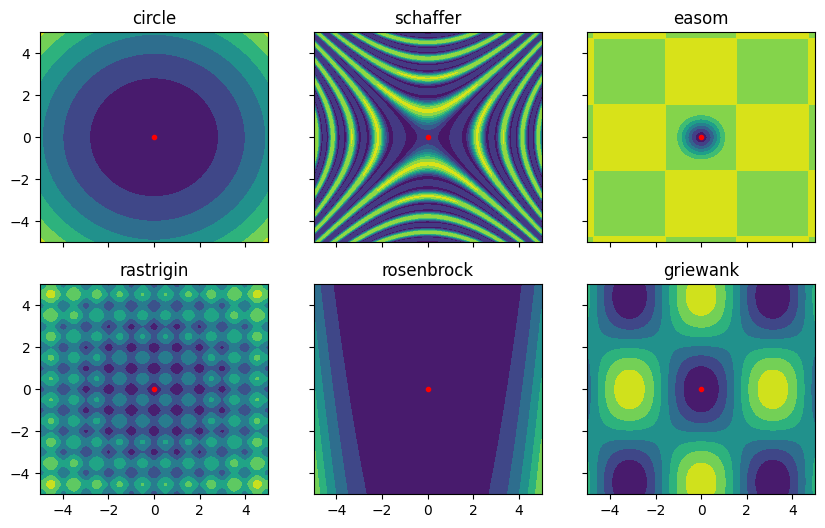

In [3]:
# plot standard landscapes

fig1, axs1 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    # landscape.rotation = rotation
    fit = landscape(pts)
    ax = axs1[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.set_title(landscape.name)

Rotation of 0.4*pi
Minimum = (1, -2)


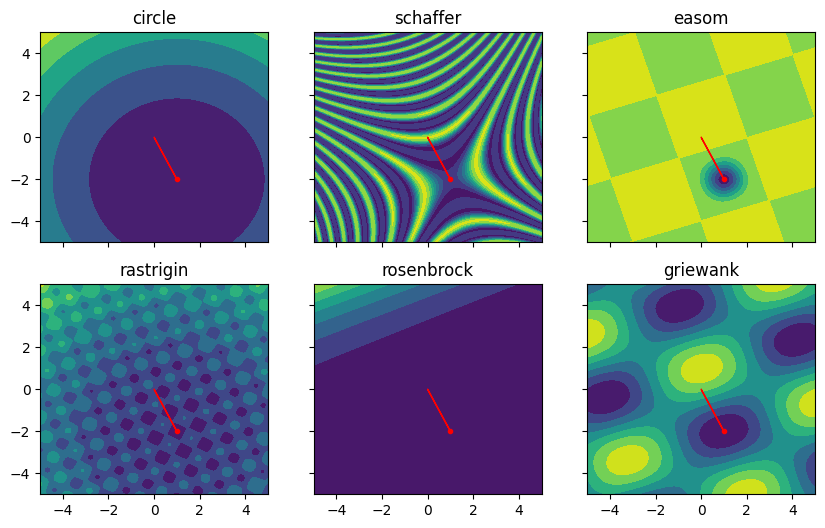

In [4]:
# plot rotated/translated landscapes

angle = 0.4 # pi/4
rotation = generate_rotation_matrix(angle*np.pi)
minimum = np.array([[1, -2]])
print(f'Rotation of {angle}*pi')
print(f'Minimum = ({minimum[0, 0]}, {minimum[0, 1]})')

fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = Landscape(landscapes_names[i], landscapes_dict[landscapes_names[i]])
    landscape.rotation = rotation
    landscape.minimum = minimum
    fit = landscape(pts)
    ax = axs2[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minimum[0, 0], landscape.minimum[0, 1], color='red', s=9)
    ax.arrow(0, 0, landscape.minimum[0, 0], landscape.minimum[0, 1], color='red')
    ax.set_title(landscape.name)

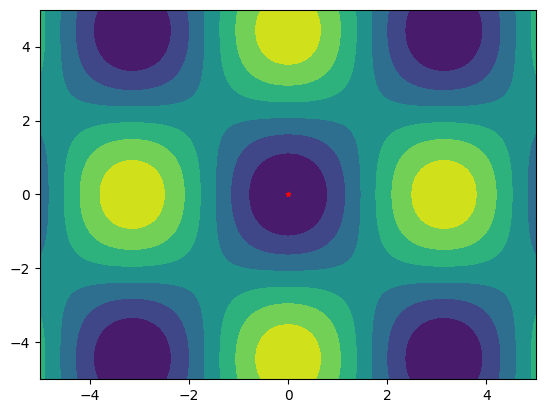

In [5]:
# plot single landscape

fit = griewank(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)

plt.scatter(0, 0, color='red', marker='*', s=9)

# Swarm class

Ideas: ahving velocity update as a function prevents from updating parameter (the internal parameters are always he same, i canno apply decay). This could be solved by implementing a class for the velocity update.

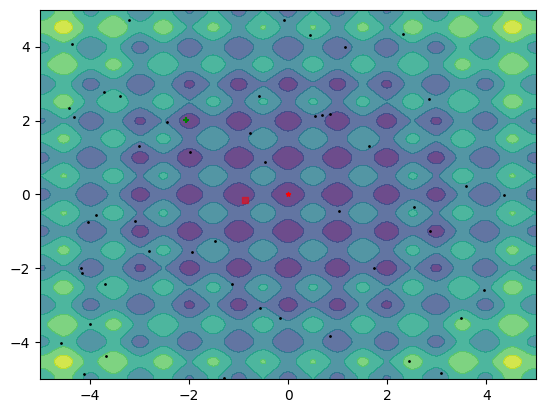

In [12]:
S = SwarmGP(50)
S.default_start(land=RASTRIGIN)

plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9) # -959.64066271
S.plot()

In [13]:
S.generate(100)
S.describe()

best fit value = 8.402463436141261e-08
best solution = [-1.75463299e-06  2.05048632e-05]
center of mass = [-0.43000479  0.08618777]
dispersion = 0.8280820504084339


(-5.0, 5.0)

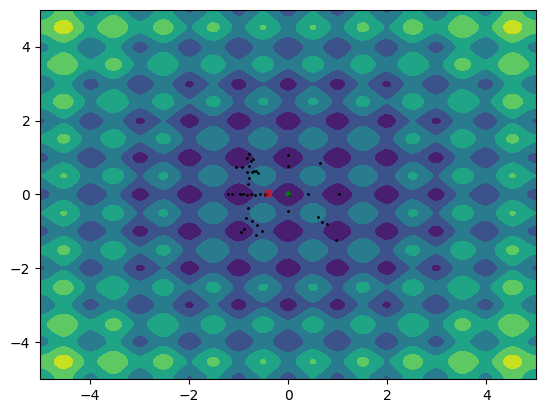

In [14]:
S.generate(100)
fit = RASTRIGIN(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
S.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Benchmark

We start with just one class of problems (e.g. rastrigin) and try to create a program for this class. Later will be extended to multiple classes. We will generate our solutions only in the [-5, 5] range and move the center in the [-2, 2] of the function. Later we can introduce also scaling of variables and scaling of outputs. But first we only deal with translation.

Paper arrpoach:
- 10 random problems with minima positioned randomly in $[-G, G]^2$ with G=1 or G=2.
- 10 particles, 30 iterations each
- initial coordinates drawn randomly in $[-5, 5]^2$ and velocities set to zero
- for each problem the PSO was run 5 times with initial random configuration
- velocities constrained in [-2, 2]

In [9]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

best fit value = 0.03245550149781451
best solution = [ 0.01278637 -0.00043459]
center of mass = [0.21070229 0.21949291]
dispersion = 0.9298931401860087


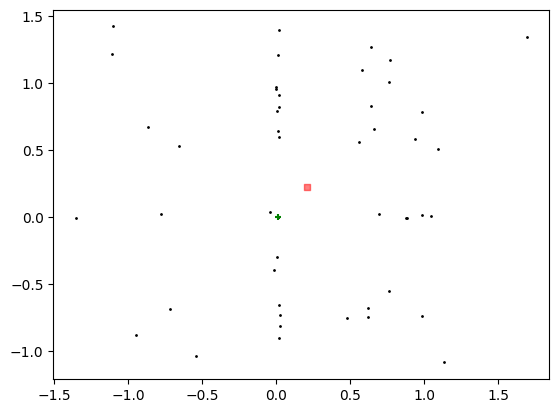

In [15]:
S = SwarmGP(SWARM_SIZE)
S.default_start(land=RASTRIGIN)
S.generate(NUM_ITERATIONS)
S.plot()
S.describe()

In [ ]:
# def BaseFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.99, inertia_min=0):

#     num_problems = 100
#     t = 5
#     problems_minima = np.zeros((100*t, 2))
#     problems = []

#     for i in range(num_problems):
#         land = random.choice(basic_landscapes)

#         # Create a new instance of the chosen landscape to avoid decoratros mess
#         land = Landscape(land.name, land.func, land.minima.copy())
#         new_minima = np.random.uniform(-2, 2, size=(2,))
#         land.modify_minima(new_minima)

#         problems_minima[i*t: i*t+t] = new_minima

#         for _ in range(t):
#             problems.append(land)

#     raw_results = np.zeros(len(problems))
#     results = np.zeros(num_problems)
#     swarms_record = []
#     best_record = np.zeros((len(problems), 2))

#     for i in range(len(problems)):
#         land = problems[i]
#         S = Swarm(SWARM_SIZE, land.func, soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
#         S.generate(NUM_ITERATIONS)
#         best_record[i] = S.global_best
#         swarms_record.append(S)

#     # Clear problems to release memory: OLD
#     # del problems
#     # gc.collect()

#     # Process results
#     raw_results = distance(best_record, problems_minima)
#     results = raw_results.reshape((-1, 5)).mean(axis=1)

#     return results


In [16]:
# results = BaseFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.01, inertia_min=0)

## NEW FITNESS

In [17]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100

In [24]:
def generate_problems(NUM_PROBLEMS):
    problems = []
    new_minima = np.random.uniform(-2, 2, size=(NUM_PROBLEMS, 2))
    angles = np.random.uniform(0, 2, (NUM_PROBLEMS,))
    for i in range(NUM_PROBLEMS):
        name = random.choice(landscapes_names)
        land = Landscape(name, landscapes_dict[name])
        land.minimum = new_minima[i]
        angle = angles[i]
        land.rotation = generate_rotation_matrix(angle*np.pi)
        problems.append(land)
    return problems

In [28]:
problems = generate_problems(NUM_PROBLEMS)

S = SwarmGP(SWARM_SIZE)

In [36]:
def PSOResults(swarm: SwarmGP, problems):
    """Returns an array of the best result obtained by the PSO on the problems contained in the problems list"""

    n_problems = len(problems)
    
    results = np.zeros(n_problems)
    swarms_best = np.zeros((len(problems), 2))
    problems_minima = np.zeros((n_problems, 2))

    for i in range(n_problems):
        problems_minima = problems[i].minimum
        swarm.default_start(land=problems[i])
        swarm.generate(NUM_ITERATIONS)
        swarms_best[i] = swarm.global_best

    # Process results
    results = distance(swarms_best, problems_minima)

    return results

In [37]:
results = PSOResults(S, problems)

In [38]:
np.std(results), np.mean(results), np.median(results)

(0.7717528093878736, 1.8009093753751175, 1.7308853611806712)

In [39]:
float(np.median(results) + np.std(results))

2.5026381705685448

# Hyperparameter optimization

In [40]:
def original_update_dec(soc_factor, cog_factor, inertia_weight):

    def new_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion):
        return original_update(n, swarm, velocity, global_best, personal_best, center_mass, dispersion, soc_factor=soc_factor, cog_factor=cog_factor, inertia_weight=inertia_weight)
    return new_update

In [41]:
# def objective(trial):
#     soc_factor = trial.suggest_float('soc_factor', 0, 5)
#     cog_factor = trial.suggest_float('cog_factor', 0, 5)
#     inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
#     # inertia_decay = trial.suggest_float('inertia_decay', 0, 1)
#     # inertia_min = trial.suggest_float('inertia_min', 0, 5)
#     vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)

#     # results = GPFitness(soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
#     results = BaseFitness(soc_factor, cog_factor, inertia_weight)

#     return float(np.median(results) + np.std(results))

In [42]:
def GPObjective(trial):
    soc_factor = trial.suggest_float('soc_factor', 0, 5)
    cog_factor = trial.suggest_float('cog_factor', 0, 5)
    inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
    vel_update = original_update_dec(soc_factor, cog_factor, inertia_weight)
    swarm = SwarmGP(SWARM_SIZE, vel_update=vel_update)

    results = PSOResults(swarm, generate_problems(NUM_PROBLEMS))

    return float(np.median(results) + np.std(results))

In [75]:
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "optimization_folder/modular_version1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
study.optimize(GPObjective, n_trials=200, )

[I 2024-12-09 15:41:22,365] Using an existing study with name 'optimization_folder/modular_version1' instead of creating a new one.
[I 2024-12-09 15:41:23,828] Trial 200 finished with value: 3.5870046479329254 and parameters: {'soc_factor': 2.668950323793081, 'cog_factor': 1.4255265096309246, 'inertia_weight': 0.23467119496510463}. Best is trial 112 with value: 2.407428050111522.
[I 2024-12-09 15:41:25,139] Trial 201 finished with value: 3.360063584360531 and parameters: {'soc_factor': 0.2767155822586428, 'cog_factor': 0.584510732117484, 'inertia_weight': 0.5318521277022012}. Best is trial 112 with value: 2.407428050111522.
[I 2024-12-09 15:41:26,426] Trial 202 finished with value: 2.985908033266056 and parameters: {'soc_factor': 0.0737292415685506, 'cog_factor': 0.21534716148051114, 'inertia_weight': 0.6190655599058124}. Best is trial 112 with value: 2.407428050111522.
[I 2024-12-09 15:41:27,738] Trial 203 finished with value: 3.584601694865487 and parameters: {'soc_factor': 0.1762172

In [45]:
study.best_params

{'soc_factor': 0.14080761970470904,
 'cog_factor': 1.1706132467936463,
 'inertia_weight': 0.8095142185705371}

In [ ]:
[p.name for p in problems]

['griewank',
 'griewank',
 'schaffer',
 'schaffer',
 'griewank',
 'circle',
 'rosenbrock',
 'rastrigin',
 'schaffer',
 'rastrigin',
 'easom',
 'rosenbrock',
 'rastrigin',
 'griewank',
 'circle',
 'schaffer',
 'griewank',
 'rastrigin',
 'griewank',
 'rosenbrock',
 'rosenbrock',
 'rastrigin',
 'circle',
 'rastrigin',
 'schaffer',
 'rosenbrock',
 'circle',
 'schaffer',
 'griewank',
 'griewank',
 'easom',
 'rosenbrock',
 'rastrigin',
 'schaffer',
 'rosenbrock',
 'rastrigin',
 'rastrigin',
 'rosenbrock',
 'rosenbrock',
 'rastrigin',
 'griewank',
 'rastrigin',
 'griewank',
 'schaffer',
 'rastrigin',
 'circle',
 'easom',
 'circle',
 'easom',
 'rosenbrock',
 'schaffer',
 'griewank',
 'schaffer',
 'schaffer',
 'griewank',
 'circle',
 'easom',
 'rastrigin',
 'rastrigin',
 'schaffer',
 'griewank',
 'griewank',
 'schaffer',
 'schaffer',
 'easom',
 'schaffer',
 'schaffer',
 'easom',
 'easom',
 'schaffer',
 'rastrigin',
 'easom',
 'easom',
 'rastrigin',
 'rastrigin',
 'griewank',
 'circle',
 'circle

In [78]:
study.trials[0].params

{'soc_factor': 1.9304788271381101,
 'cog_factor': 3.569161362243448,
 'inertia_weight': 1.7156740861360131}

In [87]:
soc = []
cog = []
inertia = []
score = []
for t in study.trials:
    if t.value < 3.5:
        params = t.params
        soc.append(params['soc_factor'])
        cog.append(params['cog_factor'])
        inertia.append(params['inertia_weight'])
        score.append(1/t.value)

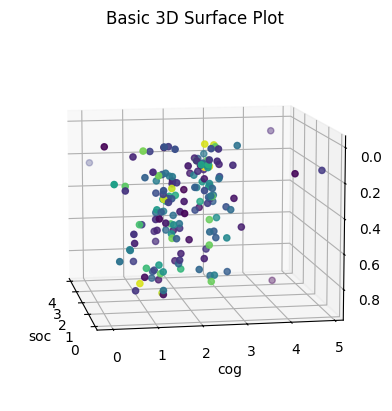

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Creating data
x = np.array(soc)
y = np.array(cog)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Creating a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the basic 3D surface
# ax.plot_surface(X, Y, Z, cmap='viridis')
ax.scatter(soc, cog, inertia, c=score)


# Customizing the plot
ax.set_xlabel('soc')
ax.set_ylabel('cog')
ax.set_zlabel('Z-axis')
ax.set_title('Basic 3D Surface Plot')
ax.view_init(-170, 10)

# Displaying the plot
plt.show()